<a href="https://colab.research.google.com/github/yanamushka/ML-course/blob/main/%22HW_2_2_%D0%9B%D0%BE%D0%B3%D1%96%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%96%D1%8F_%D0%B7_scikit_learn_ipynb%22_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1]:
pip install opendatasets --upgrade --quiet

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od
import os
import plotly.express as px

In [3]:
datset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2/data?select=test.csv'

In [4]:
od.download(datset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yanamushka
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 80.1MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu-course-c-2/bank-customer-churn-prediction-dlu-course-c-2.zip to ./bank-customer-churn-prediction-dlu-course-c-2


In [5]:
data_dir = './bank-customer-churn-prediction-dlu-course-c-2'

In [6]:
train_csv = data_dir + '/train.csv'

In [7]:
raw_df = pd.read_csv(train_csv)

In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train_val_df, test_df = train_test_split(raw_df, test_size = 0.2, random_state=42, stratify = raw_df['Exited'])
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42, stratify = train_val_df['Exited'])

In [11]:
print(f'Train df shape: {train_df.shape}')
print(f'Test df shape: {test_df.shape}')
print(f'Val df shape: {val_df.shape}')

Train df shape: (9000, 14)
Test df shape: (3000, 14)
Val df shape: (3000, 14)


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

Для вхідних незалежних даних відкидаємо колонки з назвами id, Customer_id, Surname - так як вони не будуть інформативні для побудови моделі

In [12]:
input_cols = list(train_df.columns)[3:13]
target_col = 'Exited'

In [13]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [14]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [15]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [16]:
numeric_cols = train_inputs.select_dtypes(include = np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include = 'object').columns.tolist()

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [17]:
train_inputs[numeric_cols].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,658.575111,37.677556,5.017667,43029.886138,1.589444,0.790444,0.490222,117966.921382
std,71.998600,8.123014,2.776367,59826.879389,0.533154,0.407014,0.499932,45719.047335
min,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,603.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,83092.525000
50%,661.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123542.165000
75%,708.000000,42.000000,7.000000,109735.032500,2.000000,1.000000,1.000000,157097.090000
max,850.000000,72.000000,10.000000,209767.310000,4.000000,1.000000,1.000000,199992.480000


In [18]:
train_inputs[categorical_cols].nunique()

,0
Geography,3
Gender,2


In [19]:

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

Закодуємо категоріальні дані колонки Gender за допомогою LabelEncode так як маємо лише 2 категорії, а колонки Geography за допомогою OneHotEncoder так як потрібно закодувати 3 колонки.

In [20]:
label_enc = LabelEncoder()
train_inputs['Gender_enc'] = label_enc.fit_transform(train_inputs['Gender'])
val_inputs['Gender_enc'] = label_enc.transform(val_inputs['Gender'])



In [21]:
from math import e
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
onehot.fit(train_inputs[['Geography']])
encoded_cols = list(onehot.get_feature_names_out())

In [22]:
encoded_cols

['Geography_France', 'Geography_Germany', 'Geography_Spain']

In [23]:
train_inputs[encoded_cols] = onehot.transform(train_inputs[['Geography']])
val_inputs[encoded_cols] = onehot.transform(val_inputs[['Geography']])

Для масштабування числових даних використаємо MinMaxScaler

In [24]:
scaler = MinMaxScaler()
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [25]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [26]:
display(train_inputs.head(5))

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_enc,Geography_France,Geography_Germany,Geography_Spain
63,0.744630,France,Male,0.333333,0.5,0.000000,0.333333,0.0,1.0,0.449453,1,1.0,0.0,0.0
13717,0.420048,France,Male,0.314815,0.6,0.000000,0.333333,1.0,1.0,0.763684,1,1.0,0.0,0.0
13292,0.821002,France,Female,0.277778,0.6,0.578527,0.000000,1.0,0.0,0.705771,0,1.0,0.0,0.0
9615,0.369928,Spain,Male,0.555556,0.1,0.000000,0.000000,0.0,1.0,0.749746,1,0.0,0.0,1.0
1618,0.665871,France,Male,0.259259,0.5,0.000000,0.333333,1.0,0.0,0.341975,1,1.0,0.0,0.0


In [27]:
display(val_inputs.head(5))

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_enc,Geography_France,Geography_Germany,Geography_Spain
4434,0.305489,France,Male,0.407407,0.7,0.637030,0.000000,0.0,1.0,0.922939,1,1.0,0.0,0.0
8707,0.742243,France,Male,0.296296,0.7,0.000000,0.333333,0.0,1.0,0.831610,1,1.0,0.0,0.0
679,0.816229,France,Male,0.296296,0.7,0.000000,0.333333,1.0,0.0,0.470003,1,1.0,0.0,0.0
4765,0.400955,France,Male,0.388889,0.4,0.000000,0.333333,1.0,1.0,0.633986,1,1.0,0.0,0.0
9354,0.656325,Germany,Female,0.388889,0.9,0.475355,0.333333,1.0,1.0,0.652027,0,0.0,1.0,0.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [28]:
pip install pyarrow --quiet

In [29]:
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')

In [30]:
! ls

bank-customer-churn-prediction-dlu-course-c-2  train_inputs.parquet
sample_data				       val_inputs.parquet


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [31]:
X_train = pd.read_parquet('train_inputs.parquet')
X_val = pd.read_parquet('val_inputs.parquet')

In [32]:
X_train.drop(columns = ['Gender', 'Geography'], inplace = True)
X_val.drop(columns = ['Gender', 'Geography'], inplace = True)

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
model = LogisticRegression(solver = 'liblinear')

In [35]:
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

In [36]:
model.coef_.round(2)

array([[-0.87,  8.25, -0.08, -1.09, -3.79, -0.17, -1.25,  0.31, -0.85,
        -1.05,  0.55, -1.23]])

In [37]:
train_pred = model.predict(X_train)

In [38]:
val_pred = model.predict(X_val)

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [39]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, accuracy_score, auc

In [40]:
confusion_matrix(train_targets, train_pred, normalize = 'true')

array([[0.96150091, 0.03849909],
       [0.46968869, 0.53031131]])

In [44]:
round(accuracy_score(train_targets, train_pred),2)

0.87

In [97]:
def quality_esimation(targets, pred, name=''):
  print(f'Confusion_matrix {name}: ')
  print(confusion_matrix(targets, pred, normalize ="true"))
  print(f'F1 score {name}:{f1_score(targets, pred):.2f}')



In [98]:
quality_esimation(train_targets, train_pred, 'Training')

Confusion_matrix Training: 
[[0.96150091 0.03849909]
 [0.46968869 0.53031131]]
F1 score Training:0.63


In [99]:
quality_esimation(val_targets, val_pred, 'Validation')

Confusion_matrix Validation: 
[[0.95437422 0.04562578]
 [0.45499182 0.54500818]]
F1 score Validation:0.63


In [47]:
def compute_auroc_build_roc_curve(inputs, targets, name=''):
  probs = model.predict_proba(inputs)[:,1]
  fpr, tpr, thresholds = roc_curve(targets, probs)
  roc_auc = auc(fpr, tpr)
  print(f'AUROC {name}: {roc_auc:.2f}')

  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()

AUROC Training: 0.88


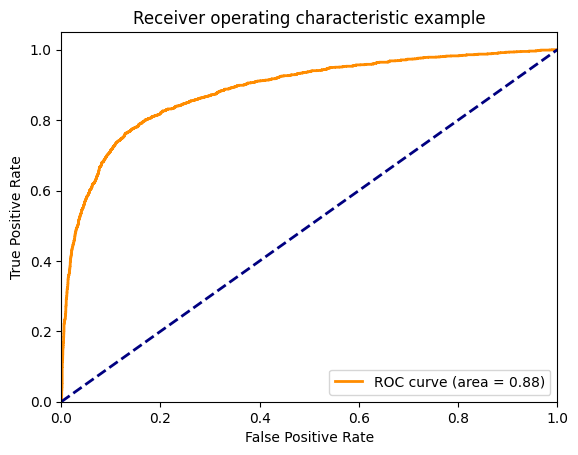

In [48]:
compute_auroc_build_roc_curve(X_train, train_targets, 'Training')

AUROC Validation: 0.88


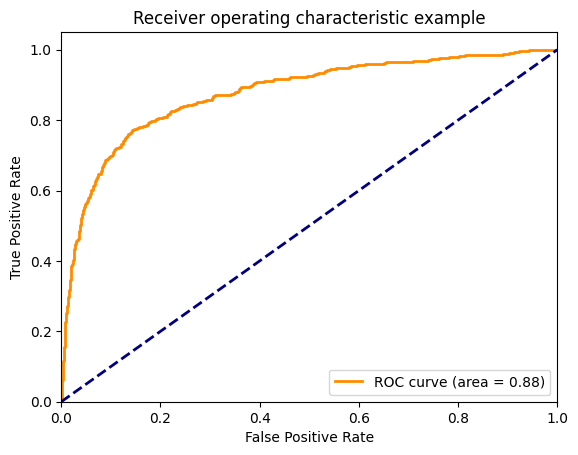

In [49]:
compute_auroc_build_roc_curve(X_val, val_targets, 'Validation')

Показник AUROC  - 0.88 для обох наборів даних, що є доволі хорошим результатом і свідчить про хорошу якість моделі. За показника F1 score 0.63 можемо зробити висновок, що якість моделі задовільна і так як це значення однакове для тренувальних та валідаційних даних, то можемо пересвідчитись, що модель працює адекватно на нових даних.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [52]:
raw_df[target_col].value_counts(normalize = True)

,proportion
Exited,
0.0,0.796533
1.0,0.203467


In [53]:
def all_zeros(inputs):
  return np.zeros(inputs.shape[0])

In [69]:
accuracy_score(train_targets, all_zeros(X_train))

0.7965555555555556

In [70]:
accuracy_score(val_targets, all_zeros(X_val))

0.7963333333333333

In [63]:
accuracy_score(train_targets, train_pred)

0.8737777777777778

In [64]:
accuracy_score(val_targets, val_pred)

0.871

Accuracy за  присвоєння передбачуваним значенням мажоритарного класу, 0.8 в той час як для моделі розрахованої з допомогою логістичної регресії цей показник становить 0.87, що свідчить про те, що логістична регресія показує кращий результат, але цей показник використовувати для оцінки якості моделі недоцільно через дисбаланс класів.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [50]:
import joblib

In [52]:
log_reg = {
    'model': model,
    'scaler': scaler,
    'encoder': onehot,
    'label_enc': label_enc,
    'numeric_cols': numeric_cols,
    'target_col': target_col,
    'input_cols': input_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}


In [53]:
joblib.dump(log_reg, 'log_reg.joblib')

['log_reg.joblib']

In [55]:
model_2 = joblib.load('log_reg.joblib')

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [78]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder,label_enc, numeric_cols, categorical_cols, input_df: pd.DataFrame):

    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df['Gender_enc'] = label_enc.transform(input_df['Gender'])
    input_df[encoded_cols] = encoder.transform(input_df[['Geography']])
    X_input = input_df[numeric_cols + ['Gender_enc']+ encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [81]:
test_raw_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/test.csv')
test_raw_df['Exited'] = predict_raw_df(scaler, onehot, label_enc, numeric_cols, categorical_cols, test_raw_df)

In [82]:
test_raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_enc,Geography_France,Geography_Germany,Geography_Spain,Exited
0,15000,15594796.0,Chu,0.365155,Germany,Male,0.222222,0.2,0.696265,0.000000,1.0,1.0,0.789477,1,0.0,1.0,0.0,0.078074
1,15001,15642821.0,Mazzi,0.286396,France,Male,0.388889,0.5,0.000000,0.333333,1.0,1.0,0.337131,1,1.0,0.0,0.0,0.035646
2,15002,15716284.0,Onyekachi,0.656325,France,Male,0.462963,0.8,0.000000,0.333333,1.0,0.0,0.783859,1,1.0,0.0,0.0,0.162224
3,15003,15785078.0,Martin,0.682578,Spain,Male,0.500000,0.3,0.000000,0.000000,1.0,1.0,0.834571,1,0.0,0.0,1.0,0.186311
4,15004,15662955.0,Kenechukwu,0.384248,Spain,Male,0.462963,0.8,0.000000,0.333333,1.0,1.0,0.718421,1,0.0,0.0,1.0,0.054261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,0.496420,Spain,Male,0.370370,1.0,0.000000,0.333333,1.0,1.0,0.248154,1,0.0,0.0,1.0,0.020180
9996,24996,15739271.0,Clements,0.589499,Spain,Male,0.388889,0.9,0.000000,0.333333,1.0,1.0,0.712578,1,0.0,0.0,1.0,0.025132
9997,24997,15756743.0,Chidiebere,0.818616,France,Male,0.222222,0.9,0.000000,0.333333,1.0,0.0,0.024253,1,1.0,0.0,0.0,0.017723
9998,24998,15680167.0,Yermakova,0.391408,France,Male,0.370370,0.6,0.690650,0.000000,1.0,0.0,0.632348,1,1.0,0.0,0.0,0.155479


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [83]:
sample_submission = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-2/sample_submission.csv')

In [84]:
sample_submission['Exited'] = test_raw_df['Exited']

In [85]:
sample_submission.head(5)

,id,Exited
0,15000,0.078074
1,15001,0.035646
2,15002,0.162224
3,15003,0.186311
4,15004,0.054261


In [86]:
sample_submission.to_csv('submission_log_reg.csv', index = False)